In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from index_evaluator import load_authors_data, evaluate_all_with_expert_index
from data_utils import load_author_publications
from index_metrics import (
    h_index, g_index, i10_index, ha_index, ar_index,
    timed_h_index, contemporary_h_index, trend_h_index,
    career_years_h_index_by_average_citations_per_year,
)
from viz_utils import *

In [3]:
# 설정
authors_file = "./gsc_data/authors.all"
data_dir = "./gsc_data/DATA/"
output_file = "all_index_results.csv"
current_year = 2013

In [4]:
# 1. 지수 계산 및 로딩
print("Calculating or loading exponents...")
authors_data = load_authors_data(authors_file)
if not os.path.exists(output_file):
    index_df, max_q, max_r = evaluate_all_with_expert_index(authors_data, data_dir, current_year)
    print(max_q, max_r)
    index_df.to_csv(output_file, index=False)
else:
    index_df = pd.read_csv(output_file)

Calculating or loading exponents...


In [5]:
start_year = 1970
end_year = 2013

authors_data = load_authors_data(authors_file)

expert_by_year_file = f"index_by_{end_year}.csv"
if not os.path.exists(expert_by_year_file):
    print(f"Calculating the full author year-by-year index...{expert_by_year_file}")
    index_df, max_q, max_r = evaluate_all_with_expert_index(authors_data, data_dir, end_year)
    print(max_q, max_r)
    index_df.to_csv(expert_by_year_file, index=False)
    print(f"Completion of calculation for {end_year}")
else:
    index_df = pd.read_csv(expert_by_year_file)
    print(f"Load completed in {end_year}")


Load completed in 2013


In [6]:
index_df_short = index_df.rename(columns=INDEX_NAME_MAP)
index_columns = list(INDEX_NAME_MAP.values())

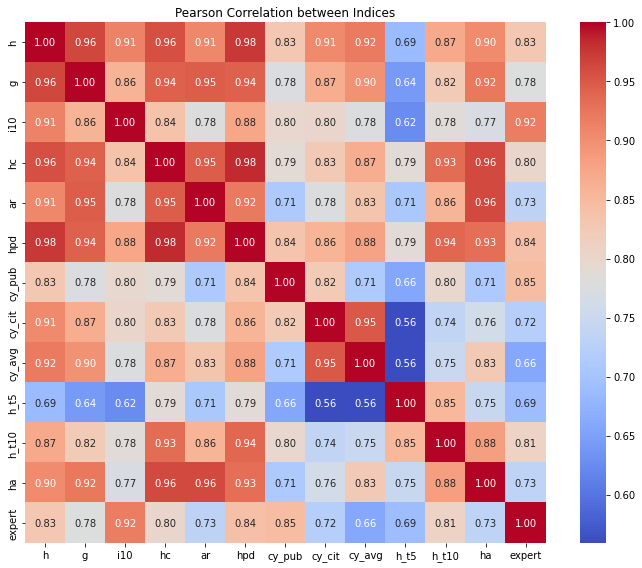

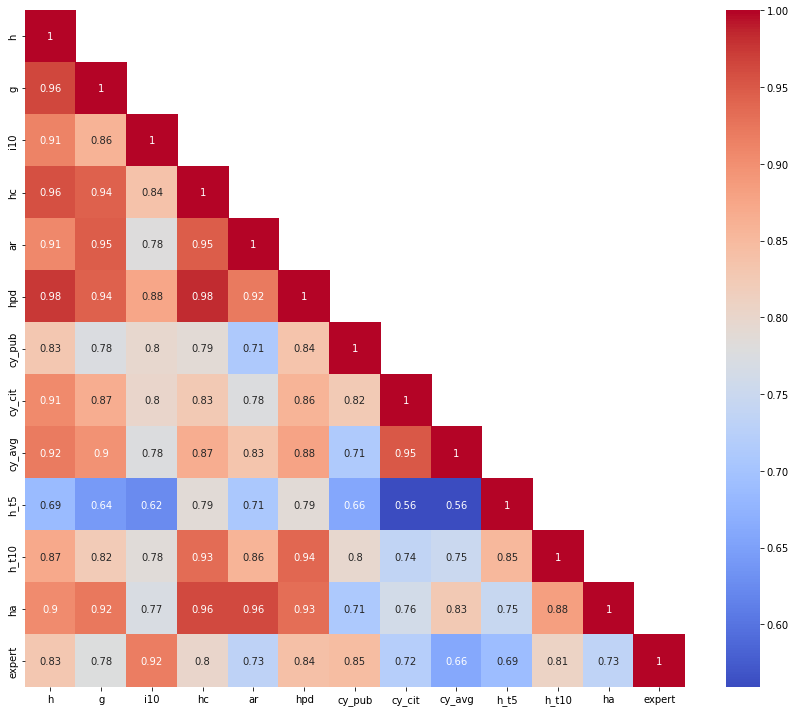

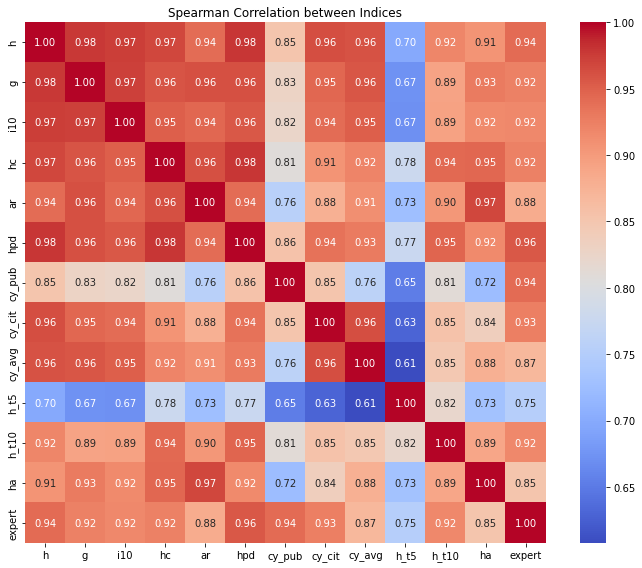

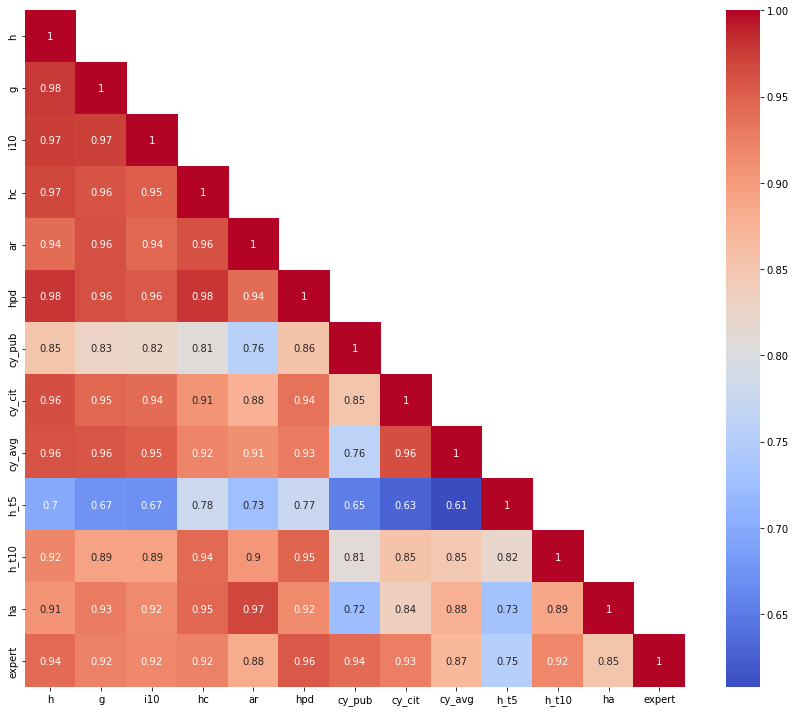

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr_pearson = plot_index_correlation_heatmap(index_df, method='pearson')
mask = np.triu(np.ones_like(corr_pearson, dtype=bool), k=1)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_pearson, annot=True, annot_kws={"size": 10}, cmap="coolwarm", mask=mask)
plt.tight_layout()
plt.savefig("pearson_heatmap.png", dpi=600)

corr_spearman = plot_index_correlation_heatmap(index_df, method='spearman')

mask = np.triu(np.ones_like(corr_spearman, dtype=bool), k=1)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_spearman, annot=True, annot_kws={"size": 10}, cmap="coolwarm", mask=mask)
plt.tight_layout()
plt.savefig("spearman_heatmap.png", dpi=600)


Comparing and Overlapping Top-K...


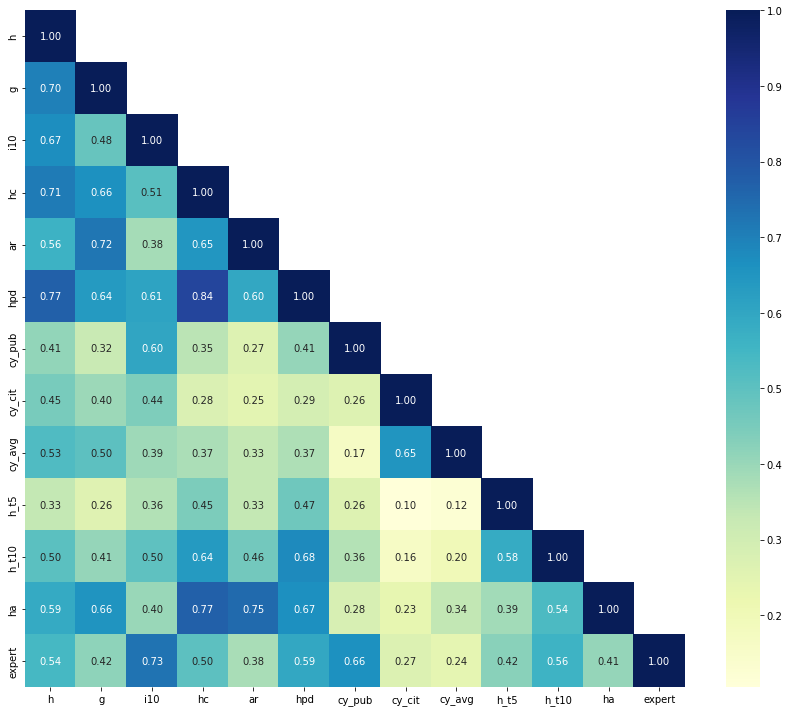

In [8]:
print("Comparing and Overlapping Top-K...")
overlap_matrix = compute_top_k_overlap_matrix(index_df_short, index_columns, k=800)
mask = np.triu(np.ones_like(overlap_matrix, dtype=float), k=1)
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix.astype(float), annot=True, fmt=".2f", annot_kws={"size": 10}, cmap="YlGnBu", mask=mask)
plt.tight_layout()
plt.savefig("top_k_overlap_heatmap.png", dpi=600)

In [10]:
print("Analyzing independent authors...")
authors_count = 0
unique_authors_by_index = find_index_specific_top_k_authors(index_df_short, index_columns, k=5)
for idx, authors in unique_authors_by_index.items():
    print(f"{len(authors)} authors included in the {idx} index as Top-K only: {authors}")
    authors_count += len(authors)

Analyzing independent authors...
0 authors included in the h index as Top-K only: set()
1 authors included in the g index as Top-K only: {'7EelTwgAAAAJ'}
0 authors included in the i10 index as Top-K only: set()
1 authors included in the hc index as Top-K only: {'g-_ZXGsAAAAJ'}
2 authors included in the ar index as Top-K only: {'ZH31nVgAAAAJ', 'D7CrQZkAAAAJ'}
1 authors included in the hpd index as Top-K only: {'Jde99xEAAAAJ'}
2 authors included in the cy_pub index as Top-K only: {'ZSpW_doAAAAJ', 'c17D_ggAAAAJ'}
1 authors included in the cy_cit index as Top-K only: {'olM19WIAAAAJ'}
1 authors included in the cy_avg index as Top-K only: {'duBlF_YAAAAJ'}
5 authors included in the h_t5 index as Top-K only: {'t53jWtYAAAAJ', 'zEQGLhoAAAAJ', 'NTY8RY8AAAAJ', '775UehEAAAAJ', 'Q0LxuhIAAAAJ'}
1 authors included in the h_t10 index as Top-K only: {'A9e6sPYAAAAJ'}
1 authors included in the ha index as Top-K only: {'sUVeH-4AAAAJ'}
2 authors included in the expert index as Top-K only: {'nhL9PHwAAAAJ', '

Visualizing the number of unique authors according to Top-K expansion...


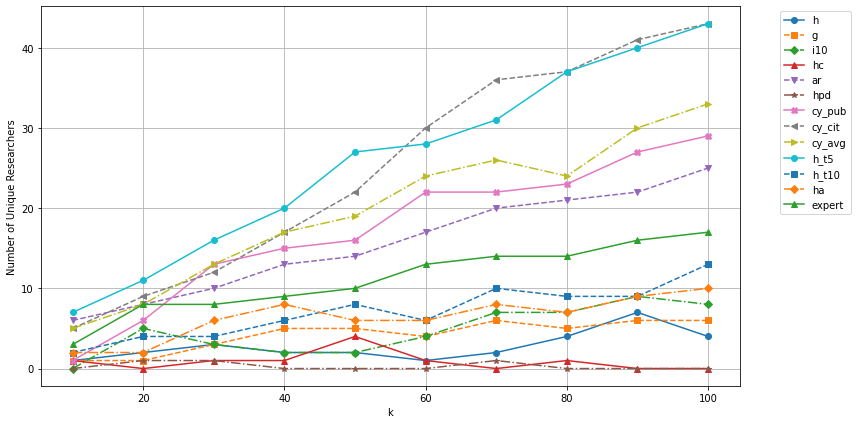

In [11]:
print("Visualizing the number of unique authors according to Top-K expansion...")
k_range = list(range(10, 110, 10))
author_counts_by_k = plot_unique_author_counts_by_k(index_df_short, index_columns, k_values=k_range)

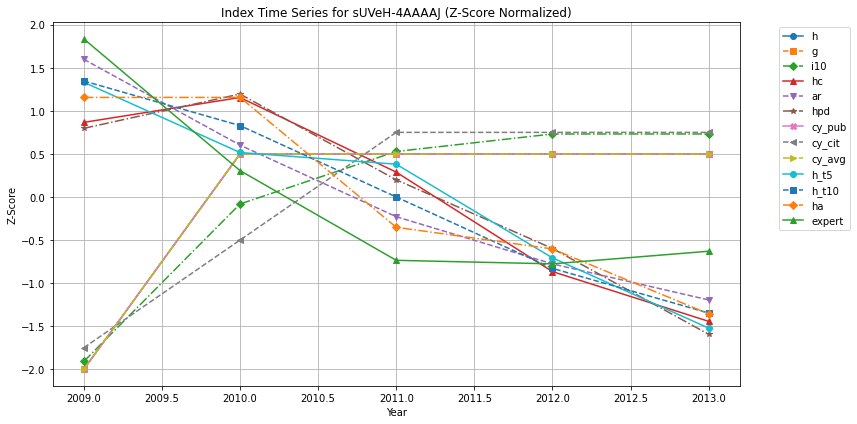

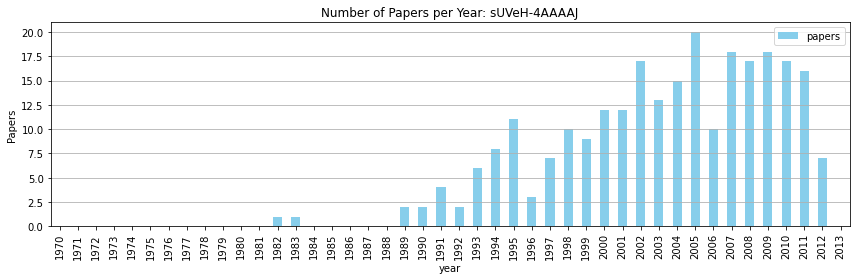

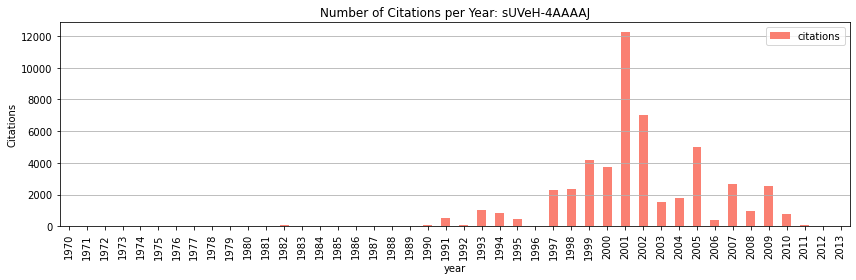

In [12]:
from data_utils import load_author_index_time_series
from viz_utils import plot_author_index_and_activity_time_series

author_id = "sUVeH-4AAAAJ"
index_df_single = load_author_index_time_series(author_id, "./", 2009, 2013)
plot_df, paper_stats = plot_author_index_and_activity_time_series(author_id, index_df_single, data_dir)


In [13]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

current_year = 2013

summary_stats = []
temporal_activity = defaultdict(list)

top_k_dict = get_top_k_authors(index_df, k=800, index_cols=None)

for index_name, author_ids in top_k_dict.items():
    for author_id in author_ids:
        df = load_author_publications(data_dir, author_id, current_year)
        df = df[(df["year"] >= 1970) & (df["year"] <= current_year)]  # ✅ 연도 필터링
        if df.empty:
            continue

        first_year = df["year"].min()
        last_year = df["year"].max()
        career_years = last_year - first_year + 1

        summary_stats.append({
            "index": index_name,
            "author_id": author_id,
            "papers": len(df),
            "total_citations": df["citations"].sum(),
            "avg_citations": df["citations"].mean(),
            "recent_5y_citations": df[df["year"] >= current_year - 5]["citations"].sum(),
            "career_years": career_years,
            "avg_year": df["year"].mean()
        })

        year_group = df.groupby("year")["citations"].sum()
        for year, c in year_group.items():
            temporal_activity[(index_name, year)].append(c)

summary_df = pd.DataFrame(summary_stats)

print("\n [Summary of Basic Statistics for Independent Authors]")
summary_table = summary_df.groupby("index").agg({
    "papers": ["mean", "std"],
    "total_citations": ["mean", "std"],
    "avg_citations": ["mean", "std"],
    "recent_5y_citations": ["mean", "std"],
    "career_years": ["mean", "std"],
    "avg_year": ["mean", "std"]
}).round(2)

weighted_avg_citations = (
    summary_df.groupby("index").apply(lambda df: df["total_citations"].sum() / df["papers"].sum())
).round(2)

summary_table[("avg_citations", "weighted")] = weighted_avg_citations

display(summary_table)

summary_table.to_excel("independent_author_stats.xlsx")
print("Save complete: independent_author_stats.xlsx")


 [Summary of Basic Statistics for Independent Authors]


papers         total_citations           avg_citations          \
                 mean     std            mean       std          mean     std   
index                                                                           
ar             301.16  291.54        23468.76  15281.60        114.59  119.57   
cy_avg         271.72  200.00        18218.63  15640.75         72.68   51.14   
cy_cit         348.04  352.92        16151.16  14676.71         53.63   47.23   
cy_pub         530.69  411.50        14888.44  14868.28         30.05   27.29   
expert         528.70  418.13        17652.79  15461.62         39.35   35.62   
g              342.14  280.12        24317.94  14476.66         88.07   61.28   
h              393.07  279.70        22516.06  14653.93         67.89   47.87   
h_t10          377.52  401.07        16844.43  14531.25         54.32   45.14   
h_t5           328.99  416.37        12747.32  14399.18         44.92   40.75   
ha             311.56  287.95        22122.01  15680.14         92.96   84.12   
hc             352.48  282.38        21887.46  15334.11         75.27   56.52   
hpd            388.08  287.65        21547.56  15048.28         65.91   46.61   
i10            490.28  403.03        19239.36  14832.56         45.47   34.40   
quality_score  503.27  421.04        19608.75  15070.65         47.14   38.63   
recency_score  518.37  421.99        11554.80  13921.37         22.28   22.16   

              recent_5y_citations          career_years       avg_year        \
                             mean      std         mean   std     mean   std   
index                                                                          
ar                        1789.11  2035.75        28.03  8.99  2002.11  3.93   
cy_avg                     759.02  1142.75        36.86  4.91  1997.44  3.66   
cy_cit                     634.99   860.25        39.06  3.54  1996.64  3.32   
cy_pub                    1090.90  1339.78        31.62  6.92  2001.72  3.07   
expert                    1501.01  1514.79        30.13  7.64  2002.80  3.14   
g                         1318.19  1673.48        32.40  7.62  2000.14  4.08   
h                         1392.28  1644.93        32.81  7.25  2000.31  3.82   
h_t10                     1821.47  1538.18        25.54  8.27  2004.15  2.83   
h_t5                      1979.70  1516.27        23.04  9.24  2005.44  2.90   
ha                        1699.56  1725.04        27.72  8.74  2002.45  3.71   
hc                        1691.09  1672.07        29.00  8.25  2002.26  3.56   
hpd                       1659.63  1614.17        29.53  7.86  2002.18  3.43   
i10                       1334.29  1501.34        32.82  7.29  2000.65  3.81   
quality_score             1515.19  1549.71        30.82  7.47  2002.01  3.34   
recency_score             1304.29  1444.79        27.55  8.19  2004.39  2.72   

              avg_citations  
                   weighted  
index                        
ar                    77.93  
cy_avg                67.05  
cy_cit                46.41  
cy_pub                28.05  
expert                33.39  
g                     71.08  
h                     57.28  
h_t10                 44.62  
h_t5                  38.75  
ha                    71.00  
hc                    62.10  
hpd                   55.52  
i10                   39.24  
quality_score         38.96  
recency_score         22.29

Save complete: independent_author_stats.xlsx


In [14]:
import pandas as pd
from data_utils import load_author_publications

def show_author_summary(author_id, index_df, data_dir, current_year=2013):
    if author_id not in index_df["author_id"].values:
        print(f"The corresponding author_id ({author_id}) does not exist in index_df.")
        return

    row = index_df[index_df["author_id"] == author_id].squeeze()
    rank_df = index_df.copy()
    for col in index_df.columns:
        if col not in {"author_id", "quality_score", "recency_score"} and pd.api.types.is_numeric_dtype(index_df[col]):
            rank_df[f"{col}_rank"] = index_df[col].rank(method="min", ascending=False)
    row_rank = rank_df[rank_df["author_id"] == author_id].squeeze()

    df = load_author_publications(data_dir, author_id, current_year=current_year)
    df = df[(df["year"] >= 2009) & (df["year"] <= current_year)]
    if df.empty or "year" not in df.columns:
        print("The paper data does not exist.")
        return

    first_year = int(df["year"].min())
    last_year = int(df["year"].max())
    career_years = last_year - first_year + 1
    paper_count = len(df)
    total_citations = int(df["citations"].sum())

    metrics = [
        col for col in index_df.columns 
        if col not in {"author_id", "quality_score", "recency_score"}
        and pd.api.types.is_numeric_dtype(index_df[col])
    ]

    data = {
        "author_id": author_id,
        "paper_count": paper_count,
        "citation_count": total_citations,
        "first_pub_year": first_year,
        "last_pub_year": last_year,
        "career_years": career_years
    }

    for col in metrics:
        data[col] = row[col]
        data[f"{col}_rank"] = int(row_rank[f"{col}_rank"])

    return pd.DataFrame([data])

In [15]:
top_k_dict = get_top_k_authors(index_df, k=5, index_cols=None)
all_unique_authors = sorted(set().union(*top_k_dict.values()))
summary_dfs = []

for author_id in all_unique_authors:
    df = show_author_summary(author_id, index_df, data_dir)
    if df is not None:
        summary_dfs.append(df)

# 전체 결과 통합
final_summary = pd.concat(summary_dfs, ignore_index=True)

# 결과 미리보기
display(final_summary.head())

output_path = "unique_authors_summary_top5_2009.csv"

# 저장
final_summary.to_csv(output_path, index=False, encoding="utf-8-sig")

print(len(final_summary))

print(f"Save complete: {output_path}")


,author_id,paper_count,citation_count,first_pub_year,last_pub_year,career_years,h_index,h_index_rank,g_index,g_index_rank,i10_index,i10_index_rank,contemporary_h_index,contemporary_h_index_rank,ar_index,ar_index_rank,hpd_index,hpd_index_rank,career_year_h_index_by_publications,career_year_h_index_by_publications_rank,career_year_h_index_by_publications_year_citations,career_year_h_index_by_publications_year_citations_rank,career_years_h_index_by_average_citations_per_year,career_years_h_index_by_average_citations_per_year_rank,timed_h_index_5,timed_h_index_5_rank,timed_h_index_10,timed_h_index_10_rank,ha_index,ha_index_rank,expert_index,expert_index_rank
0,-5nvuQIAAAAJ,23,1030,2009,2012,4,97,38,191,82,283,98,44,163,40.153383,243,72,135,12,764,47,2,40.600000,1,5,14794,28,989,18,327,7.430470,437
1,0DEykT4AAAAJ,734,4285,2009,2012,4,106,20,172,136,1253,2,52,63,44.358569,159,96,21,26,2,36,96,22.610949,535,26,32,67,5,23,96,51.221995,3
2,5q4fhUoAAAAJ,29,119,2009,2012,4,97,38,335,2,231,201,49,92,67.400106,17,74,115,13,483,41,24,34.209945,4,7,6732,19,4023,23,96,6.713326,586
3,775UehEAAAAJ,399,4639,2009,2012,4,62,415,99,1219,241,172,49,92,37.332052,345,80,67,10,1812,11,15794,10.329640,11041,35,5,62,14,22,133,14.202033,55
4,7EelTwgAAAAJ,99,1469,2009,2012,4,115,12,284,5,289,94,72,5,62.351966,27,102,11,15,187,37,71,32.578512,13,18,214,44,114,35,4,11.215487,102


33
Save complete: unique_authors_summary_top5_2009.csv
